## Amazon Rainforest project

In [1]:
import sys
import os
import subprocess
import tarfile

import numpy as np
import pandas as pd
import seaborn as sns
import mpld3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from scipy import ndimage
from IPython.display import display

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
from sklearn.metrics import fbeta_score
import timeit

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

from keras.preprocessing import image
from tqdm import tqdm

from sklearn.preprocessing import MultiLabelBinarizer

from models import*
from collections import defaultdict

%matplotlib inline

Using TensorFlow backend.
/home/aind2/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
df_train = pd.read_csv('./train_v2.csv')
df_train.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


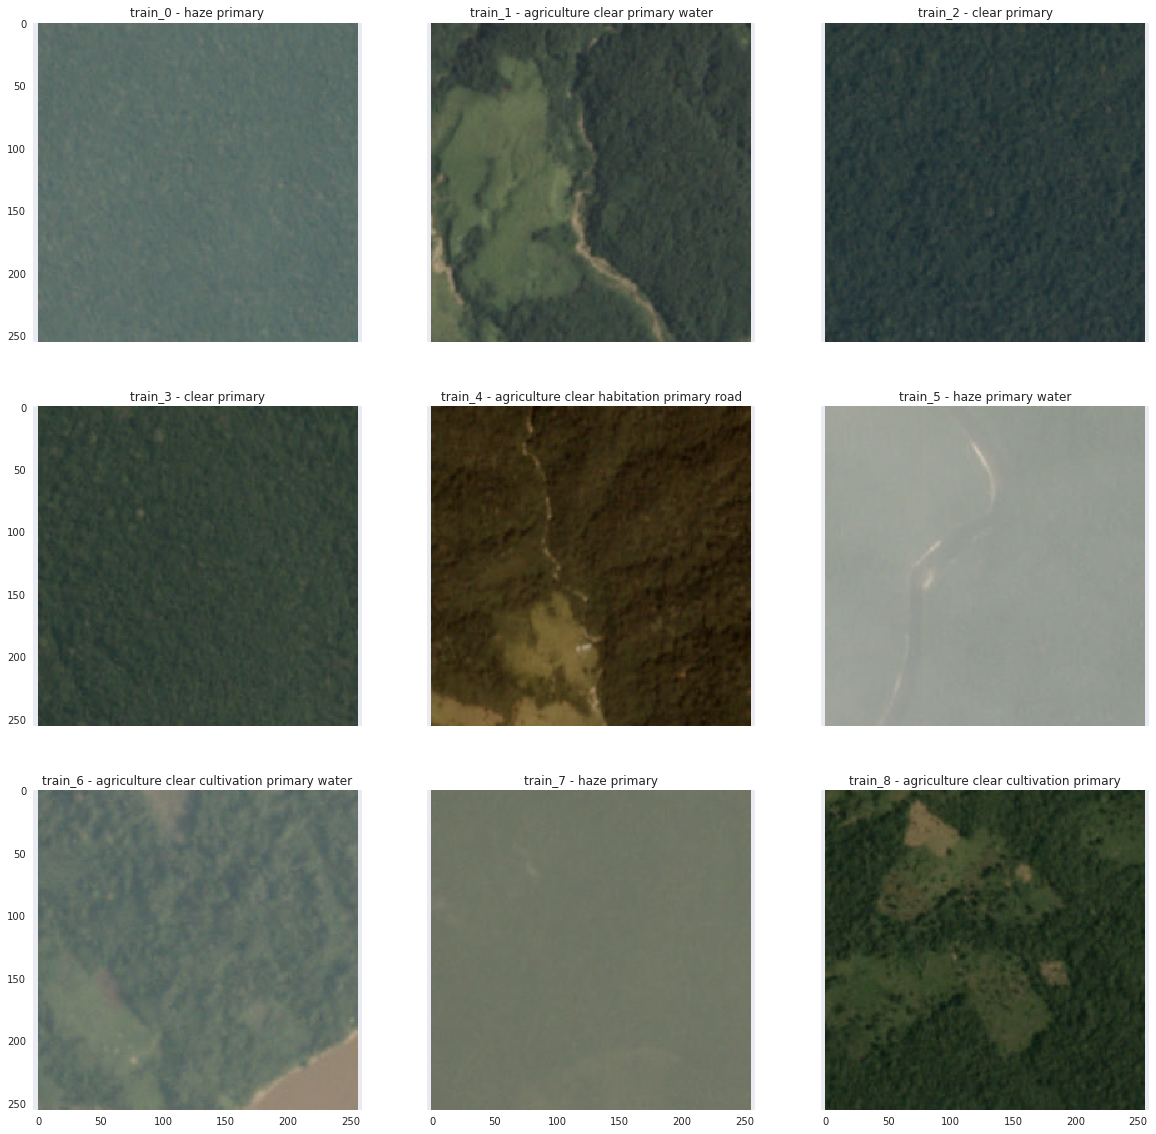

In [3]:
import cv2

new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))
i = 0

#print(df_train[['image_name','tags']][:2].values)
for f, l in df_train[['image_name','tags']][:9].values:
    img = cv2.imread('./train-jpg/{}.jpg'.format(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    i += 1
    
plt.show()

In [4]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in df_train['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'slash_burn', 'primary', 'blooming', 'cultivation', 'partly_cloudy', 'artisinal_mine', 'habitation', 'bare_ground', 'cloudy', 'blow_down', 'clear', 'road', 'water', 'conventional_mine', 'haze', 'agriculture', 'selective_logging'}


/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


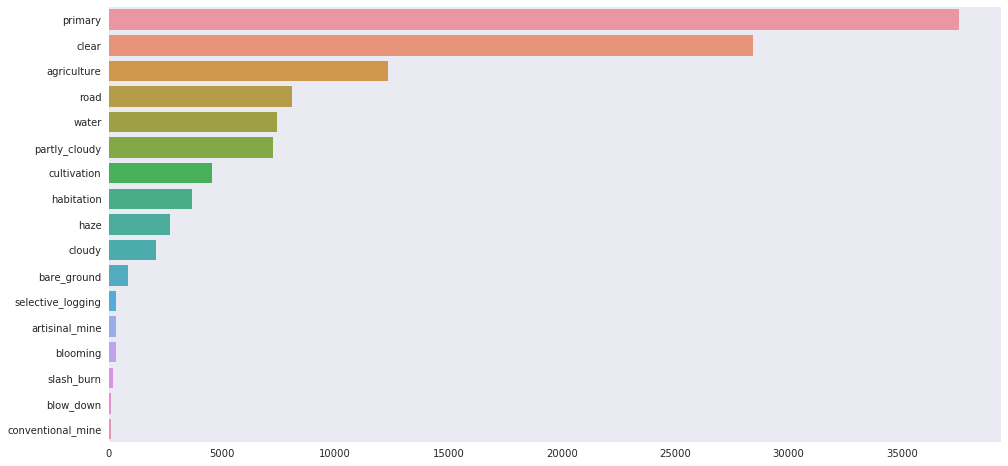

In [5]:
# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

GPU settings

In [6]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
set_session(tf.Session(config=config))

In [7]:

def path_to_tensor(img_path):
    img_path1 = str('./data/train/data_train/train-jpg/{}.jpg'.format(img_path))
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path1, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [8]:
len_train = df_train['image_name'].size

In [9]:
train_split = int(np.round(0.8*len_train))
test_split = int(np.round(0.1*len_train))
print(train_split)
print(test_split)

32383
4048


In [10]:
df_test1 = df_train[:32383]
#df_test2 = df_train[32383:]
df_test2 = df_train[train_split: train_split + test_split]
df_test3 = df_train[train_split + test_split:]

In [11]:
labels_list1 = list(chain.from_iterable([tags.split(" ") for tags in df_test1['tags'].values]))
labels_set1 = set(labels_list1)
print("There is {} unique labels including {}".format(len(labels_set1), labels_set1))

There is 17 unique labels including {'slash_burn', 'primary', 'blooming', 'cultivation', 'partly_cloudy', 'artisinal_mine', 'habitation', 'bare_ground', 'cloudy', 'blow_down', 'clear', 'road', 'water', 'conventional_mine', 'haze', 'agriculture', 'selective_logging'}


In [12]:
labels_list2 = list(chain.from_iterable([tags.split(" ") for tags in df_test2['tags'].values]))
labels_set2 = set(labels_list2)
print("There is {} unique labels including {}".format(len(labels_set2), labels_set2))

There is 17 unique labels including {'slash_burn', 'primary', 'blooming', 'cultivation', 'partly_cloudy', 'artisinal_mine', 'habitation', 'bare_ground', 'cloudy', 'blow_down', 'clear', 'road', 'water', 'conventional_mine', 'haze', 'agriculture', 'selective_logging'}


In [13]:
labels_list3 = list(chain.from_iterable([tags.split(" ") for tags in df_test3['tags'].values]))
labels_set3 = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set3), labels_set3))

There is 17 unique labels including {'slash_burn', 'primary', 'blooming', 'cultivation', 'partly_cloudy', 'artisinal_mine', 'habitation', 'bare_ground', 'cloudy', 'blow_down', 'clear', 'road', 'water', 'conventional_mine', 'haze', 'agriculture', 'selective_logging'}


/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


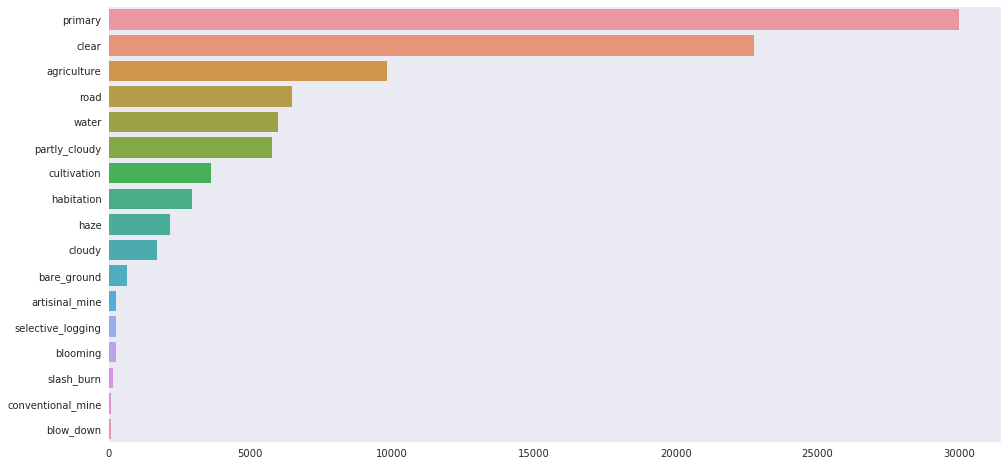

In [14]:
labels_s1 = pd.Series(labels_list1).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s1, y=labels_s1.index, orient='h')

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


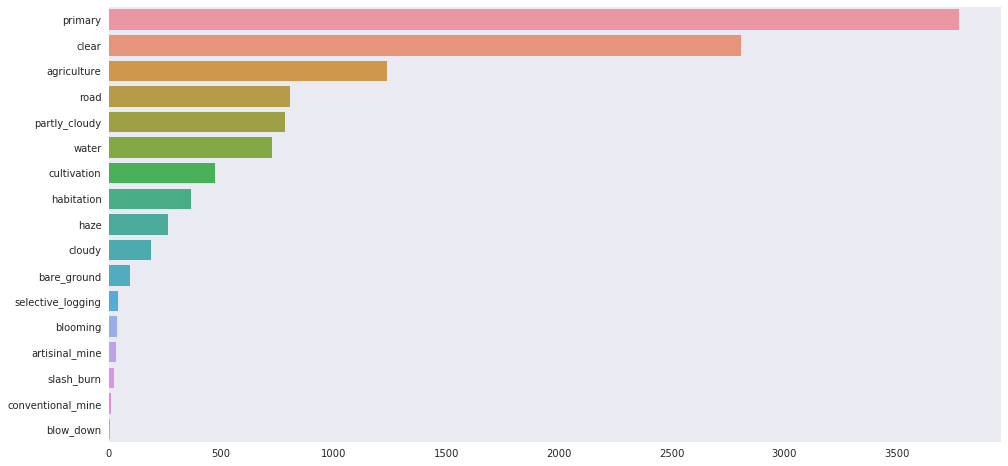

In [15]:
labels_s2 = pd.Series(labels_list2).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s2, y=labels_s2.index, orient='h')

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


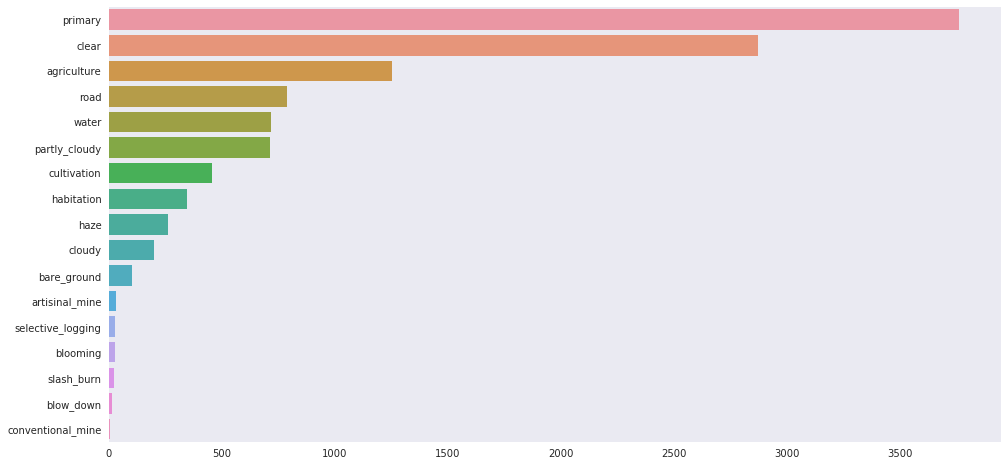

In [16]:
labels_s3 = pd.Series(labels_list3).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s3, y=labels_s3.index, orient='h')

In [17]:
df_test5 = df_train[:10]

In [18]:
labels_list1 = list(chain.from_iterable([tags.split(" ") for tags in df_test5['tags'].values]))
labels_set1 = set(labels_list1)
print("There is {} unique labels including {}".format(len(labels_set1), labels_set1))

There is 8 unique labels including {'primary', 'cultivation', 'habitation', 'clear', 'road', 'water', 'haze', 'agriculture'}


In [19]:
labels_set1

{'agriculture',
 'clear',
 'cultivation',
 'habitation',
 'haze',
 'primary',
 'road',
 'water'}

In [20]:
test_6 = df_test5['tags']
print(test_6)

0                                   haze primary
1                agriculture clear primary water
2                                  clear primary
3                                  clear primary
4      agriculture clear habitation primary road
5                             haze primary water
6    agriculture clear cultivation primary water
7                                   haze primary
8          agriculture clear cultivation primary
9     agriculture clear cultivation primary road
Name: tags, dtype: object


In [21]:
mlb = MultiLabelBinarizer()
y_targets = mlb.fit_transform(s.split() for s in test_6)

In [22]:
df_test1 = df_train[:32383]
df_test2 = df_train[train_split: train_split + test_split]
df_test3 = df_train[train_split + test_split:]

In [23]:
train_files = df_train[:train_split]
val_files = df_train[train_split: train_split + test_split]
test_files = df_train[train_split + test_split :]

In [24]:

print(train_split)
print(train_split + test_split)

32383
36431


In [25]:
df_train.iloc[train_split-1]

image_name                        train_32382
tags          agriculture clear primary water
Name: 32382, dtype: object

In [26]:
train_files.loc[train_split-1]

image_name                        train_32382
tags          agriculture clear primary water
Name: 32382, dtype: object

In [27]:
val_files.loc[train_split]

image_name              train_32383
tags          partly_cloudy primary
Name: 32383, dtype: object

In [28]:
df_train.iloc[train_split]

image_name              train_32383
tags          partly_cloudy primary
Name: 32383, dtype: object

In [29]:
val_files.loc[train_split+test_split-1]

image_name     train_36430
tags          haze primary
Name: 36430, dtype: object

In [30]:
df_train.iloc[train_split+test_split-1]

image_name     train_36430
tags          haze primary
Name: 36430, dtype: object

In [31]:
img_path = df_train['image_name'][0]
img_path1 = str('./train-jpg/{}.jpg'.format(img_path))
print(img_path1)
img = image.load_img(img_path1, target_size = (224,224))
print(img)
x = image.img_to_array(img)
print(x.shape)
x = np.expand_dims(x, axis=0)
print(x.shape)

./train-jpg/train_0.jpg
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F8B840542B0>
(224, 224, 3)
(1, 224, 224, 3)


In [32]:
def one_hot(target):
    mlb = MultiLabelBinarizer()
    y_targets = mlb.fit_transform(s.split() for s in target)
    return y_targets

In [33]:
one_hot(df_test5['tags'])

array([[0, 0, 0, 0, 1, 1, 0, 0],
       [1, 1, 0, 0, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0],
       [1, 1, 0, 1, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 1, 0, 1],
       [1, 1, 1, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 1, 0, 0],
       [1, 1, 1, 0, 0, 1, 0, 0],
       [1, 1, 1, 0, 0, 1, 1, 0]])

In [34]:
df_test5['tags']

0                                   haze primary
1                agriculture clear primary water
2                                  clear primary
3                                  clear primary
4      agriculture clear habitation primary road
5                             haze primary water
6    agriculture clear cultivation primary water
7                                   haze primary
8          agriculture clear cultivation primary
9     agriculture clear cultivation primary road
Name: tags, dtype: object

In [35]:
def path_to_tensor(img_path):
    img_path1 = str('./train-jpg/{}.jpg'.format(img_path))
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path1, target_size=(128, 128))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Normalise the data

In [36]:
print(train_split)
print(train_split/4)
train_split1 = 8096
train_split2 = 8095
suma = 3*train_split1 + train_split2
print(suma)

32383
8095.75
32383


In [37]:
train_files1 = df_train[:train_split1]
train_files2 = df_train[train_split1:2*train_split1]
train_files3 = df_train[2*train_split1:3*train_split1]
train_files4 = df_train[3*train_split1:3*train_split1 + train_split2]
sum2 = len(train_files1) + len(train_files2) + len(train_files3) + len(train_files4)
print(sum2)

32383


In [38]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4154425056945806495, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 382337024
 locality {
   bus_id: 1
 }
 incarnation: 9250922474836933473
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:17.0", name: "/gpu:1"
 device_type: "GPU"
 memory_limit: 382337024
 locality {
   bus_id: 1
 }
 incarnation: 2363491368142799501
 physical_device_desc: "device: 1, name: Tesla K80, pci bus id: 0000:00:18.0", name: "/gpu:2"
 device_type: "GPU"
 memory_limit: 382337024
 locality {
   bus_id: 1
 }
 incarnation: 1614420660290724461
 physical_device_desc: "device: 2, name: Tesla K80, pci bus id: 0000:00:19.0", name: "/gpu:3"
 device_type: "GPU"
 memory_limit: 382337024
 locality {
   bus_id: 1
 }
 incarnation: 6090646450060349553
 physical_device_desc: "device: 3, name: Tesla K80, pci bus id: 0000:00:1a.0", name: "/gpu:4"
 device_type: "GPU"
 memory_limit: 384434176
 locality {
   bus_id: 1


In [39]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors1 = paths_to_tensor(train_files1['image_name']).astype('float32')/255

100%|██████████| 8096/8096 [00:24<00:00, 329.89it/s]


In [40]:
train_tensors2 = paths_to_tensor(train_files2['image_name']).astype('float32')/255

100%|██████████| 8096/8096 [00:23<00:00, 338.27it/s]


In [41]:
train_tensors3 = paths_to_tensor(train_files3['image_name']).astype('float32')/255

100%|██████████| 8096/8096 [00:24<00:00, 327.54it/s]


In [42]:
train_tensors4 = paths_to_tensor(train_files4['image_name']).astype('float32')/255

100%|██████████| 8095/8095 [00:23<00:00, 345.82it/s]


In [43]:
valid_tensors = paths_to_tensor(val_files['image_name']).astype('float32')/255

100%|██████████| 4048/4048 [00:11<00:00, 344.20it/s]


In [44]:
test_tensors = paths_to_tensor(test_files['image_name']).astype('float32')/255

100%|██████████| 4048/4048 [00:11<00:00, 337.42it/s]


In [45]:
train_tensors1.shape

(8096, 128, 128, 3)

In [46]:
train_tensors2.shape

(8096, 128, 128, 3)

In [47]:
list_train_tensors = [train_tensors1, train_tensors2, train_tensors3, train_tensors4]

In [48]:
train_tensors = np.vstack(list_train_tensors)

In [49]:
train_tensors.shape

(32383, 128, 128, 3)

In [50]:
valid_tensors.shape

(4048, 128, 128, 3)

In [51]:
test_tensors.shape

(4048, 128, 128, 3)

### One hot encode

In [52]:
#One hot enconded the labels
train_targets = one_hot(train_files['tags'])
valid_targets = one_hot(val_files['tags'])
test_targets = one_hot(test_files['tags'])

In [53]:
complete_data = one_hot(df_train['tags'])

In [54]:
print(complete_data[0])
print(train_targets[0])
print()
print(complete_data[train_split])
print(valid_targets[0])
print()
print(complete_data[train_split + test_split])
print(test_targets[0])

[0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]

[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]


### Test models

In [55]:
model_simple = create_model_model_simple(img_dim=(128, 128, 3))

In [56]:
model_simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        8256      
__________

In [57]:
model_base = create_model_model_base(img_dim=(128, 128, 3))

In [58]:
model_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        8256      
__________

In [59]:
model_0 = create_model_model_0(img_dim=(128, 128, 3))

In [60]:
model_0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        8256      
__________

In [61]:
model_1 = create_model_model_1(img_dim=(128, 128, 3))

In [62]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 64)      832       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 64)      16448     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 128)       32896     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 128)       65664     
__________

In [63]:
model_3 = create_model_VGG16(img_dim=(128, 128, 3))

In [64]:
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 17)                139281    
Total params: 14,853,981
Trainable params: 14,853,975
Non-trainable params: 6
_________________________________________________________________


In [65]:
model_4 = create_model_model_comb_1(img_dim=(128, 128, 3))

In [66]:
model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 64)        8256      
__________

In [67]:
model_5 = create_model_model_comb_2(img_dim=(128, 128, 3))

In [68]:
model_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 64)        8256      
__________

In [69]:
model_6 = create_model_model_comb_3(img_dim=(128, 128, 3))

In [70]:
model_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 64)        8256      
__________

### Helper functions

In [71]:
def top_prediction_vector(elem,t):
    idx = (-elem).argsort()[0]
    pred = np.sort(elem[np.where(elem>t)])[::-1]
    tensor = []
    for value in pred:
        test = np.where(value == elem[0])[0]
        tensor.append(test[0])
    p = 0*np.arange(0,len(idx))
    np.put(p,tensor,1)
    return p   

In [72]:
def stack_vector(base_predictions,t):
    list_of_tensors = [top_prediction_vector(elem,t) for elem in base_predictions]
    return np.vstack(list_of_tensors)

In [73]:
def f2_score(y_true, y_pred):
    # fbeta_score throws a confusing error if inputs are not numpy arrays
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    # We need to use average='samples' here, any other average method will generate bogus results
    return fbeta_score(y_true, y_pred, beta=2, average='samples')

In [74]:
mlb1 = MultiLabelBinarizer()
mlb1.fit(s.split() for s in test_files['tags'])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [75]:
def one_hot_matrix(prediction):
    
    list_final=[]
    
    for p in prediction:
        p = p.reshape(1,17)
        y_targets = mlb1.inverse_transform(p)
        list_1 = [elem for elem in y_targets[0]]
        list_final.append(list_1)
    return list_final

In [76]:
def create_confusion_matrix(data, predictions):
    
    confusion = defaultdict(int)
    for i in range(len(predictions)):
        
        gold_label = data[i]
        p_labels = predictions[i]
        
        gold_label_set = set(gold_label)
        p_labels_set = set(p_labels)

        equal = gold_label_set.intersection(p_labels_set)
        for elem in equal:
            confusion[(elem, elem)] += 1

        gold = gold_label_set.difference(p_labels_set)
        for y_gold in gold:
            confusion[(y_gold, 'None')] += 1

        pred = p_labels_set.difference(gold_label_set)
        for y_guess in pred:
            confusion[('None', y_guess)] += 1
    
    return confusion

In [77]:
def evaluate(conf_matrix, label_filter=None):
    """
    Evaluate Precision, Recall and F1 based on a confusion matrix as produced by `create_confusion_matrix`.
    Args:
        conf_matrix: a confusion matrix in form of a dictionary from `(gold_label,guess_label)` pairs to counts.
        label_filter: a set of gold labels to consider. If set to `None` all labels are considered.

    Returns:
        Precision, Recall, F1 triple.
    """
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for (gold, guess), count in conf_matrix.items():
        if label_filter is None or gold in label_filter or guess in label_filter:
            if gold == 'None' and guess != gold:
                fp += count
            elif gold == 'None' and guess == gold:
                tn += count
            elif gold != 'None' and guess == gold:
                tp += count
            elif gold != 'None' and guess == 'None':
                fn += count
            else:  # both gold and guess are not-None, but different
                fp += count if label_filter is None or guess in label_filter else 0
                fn += count if label_filter is None or gold in label_filter else 0
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f2 = 5/4 * prec * recall / (prec + recall) if prec * recall > 0 else 0.0
    
    return prec, recall

In [78]:
def full_evaluation_table(confusion_matrix):
    """
    Produce a pandas data-frame with Precision, F1 and Recall for all labels.
    Args:
        confusion_matrix: the confusion matrix to calculate metrics from.

    Returns:
        a pandas Dataframe with one row per gold label, and one more row for the aggregate of all labels.
    """
    labels = sorted(list({l for l, _ in confusion_matrix.keys()} | {l for _, l in confusion_matrix.keys()}))
    gold_counts = defaultdict(int)
    guess_counts = defaultdict(int)
    for (gold_label, guess_label), count in confusion_matrix.items():
        if gold_label != "None":
            gold_counts[gold_label] += count
            gold_counts["[All]"] += count
        if guess_label != "None":
            guess_counts[guess_label] += count
            guess_counts["[All]"] += count

    result_table = []
    for label in labels:
        if label != "None":
            result_table.append((label, gold_counts[label], guess_counts[label], *evaluate(confusion_matrix, {label})))

    result_table.append(("[All]", gold_counts["[All]"], guess_counts["[All]"], *evaluate(confusion_matrix)))
    return pd.DataFrame(result_table, columns=('Label', 'Gold', 'Guess', 'Precision', 'Recall'))

In [79]:
def plot_confusion_matrix_dict(matrix_dict, rotation=45, outside_label=""):
    labels = set([y for y, _ in matrix_dict.keys()] + [y for _, y in matrix_dict.keys()])
    sorted_labels = sorted(labels)
    matrix = np.zeros((len(sorted_labels), len(sorted_labels)))
    for i1, y1 in enumerate(sorted_labels):
        for i2, y2 in enumerate(sorted_labels):
            if y1 != outside_label or y2 != outside_label:
                matrix[i1, i2] = matrix_dict[y1, y2]
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(sorted_labels))
    plt.xticks(tick_marks, sorted_labels, rotation=rotation)
    plt.yticks(tick_marks, sorted_labels)
    plt.tight_layout()
    # return matrix

### Simpler Baseline

In [83]:
model_simple = create_model_model_simple(img_dim=(128, 128, 3))

In [84]:
model_simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 64)        8256      
__________

In [78]:
#Compile the model with Adam
model_simple.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])

In [79]:
#callbacks
history_simple = History()
callbacks_simple = [history_simple, 
                 EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
                 ModelCheckpoint(filepath='saved_models/model_simple.weights.best.from_scratch.hdf5', verbose=1, 
                             save_best_only=True)]

In [80]:
#fit
epochs = 25
batchsize = 256

start = timeit.default_timer()

hist_simple = model_simple.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
                 epochs=epochs, batch_size=batchsize, callbacks=callbacks_simple, verbose=1)

end = timeit.default_timer()-start
print("{} min".format(end/60))

Train on 32383 samples, validate on 4048 samples
Epoch 1/25
32383/32383 [==============================] - 40s 1ms/step - loss: 0.6089 - acc: 0.7059 - val_loss: 0.5812 - val_acc: 0.8594
Epoch 2/25
32383/32383 [==============================] - 38s 1ms/step - loss: 0.3163 - acc: 0.9045 - val_loss: 0.3341 - val_acc: 0.9097
Epoch 3/25
32383/32383 [==============================] - 38s 1ms/step - loss: 0.2556 - acc: 0.9096 - val_loss: 0.2612 - val_acc: 0.9089
Epoch 4/25
32383/32383 [==============================] - 38s 1ms/step - loss: 0.2436 - acc: 0.9094 - val_loss: 0.2415 - val_acc: 0.9088
Epoch 5/25
32383/32383 [==============================] - 38s 1ms/step - loss: 0.2365 - acc: 0.9096 - val_loss: 0.2345 - val_acc: 0.9090
Epoch 6/25
32383/32383 [==============================] - 38s 1ms/step - loss: 0.2315 - acc: 0.9099 - val_loss: 0.2297 - val_acc: 0.9099
Epoch 7/25
32383/32383 [==============================] - 38s 1ms/step - loss: 0.2269 - acc: 0.9113 - val_loss: 0.2257 - val_acc:

In [85]:
model_simple.load_weights('saved_models/model_simple.weights.best.from_scratch.hdf5')

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


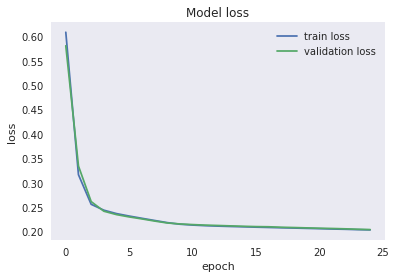

In [82]:
plt.plot(hist_simple.history['loss'])
plt.plot(hist_simple.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [86]:
# get predictions
baseline_predictions_simple = [np.argmax(model_simple.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
base_predictions_simple = [model_simple.predict(np.expand_dims(tensor, axis=0)) for tensor in test_tensors]

In [91]:
result_simple= stack_vector(base_predictions_simple,0.2)

In [92]:
print('F2 Score Model 0:', f2_score(test_targets, result_simple))

F2 Score Model 0: 0.790966477792


In [ ]:
### Confusion Matrix

In [93]:
predictions_simple = one_hot_matrix(result_simple)

In [94]:
data_targets = [item.split()for item in test_files['tags'].tolist()]

In [95]:
matrix_confusion_simple = create_confusion_matrix(data_targets, predictions_simple)

In [96]:
full_evaluation_table(matrix_confusion_simple)

Label   Gold  Guess  Precision    Recall
0         agriculture   1251   2428   0.453460  0.880096
1      artisinal_mine     35      0   0.000000  0.000000
2         bare_ground    102     52   0.230769  0.117647
3            blooming     27      0   0.000000  0.000000
4           blow_down     13      0   0.000000  0.000000
5               clear   2873   3619   0.788063  0.992691
6              cloudy    199    275   0.545455  0.753769
7   conventional_mine      7      0   0.000000  0.000000
8         cultivation    451     97   0.072165  0.015521
9          habitation    346    462   0.272727  0.364162
10               haze    262    470   0.442553  0.793893
11      partly_cloudy    714   1723   0.289031  0.697479
12            primary   3759   4025   0.933665  0.999734
13               road    789   1273   0.447761  0.722433
14  selective_logging     28      0   0.000000  0.000000
15         slash_burn     24      0   0.000000  0.000000
16              water    716    840   0.320238  0.375698
17              [All]  11596  15264   0.625721  0.823646

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


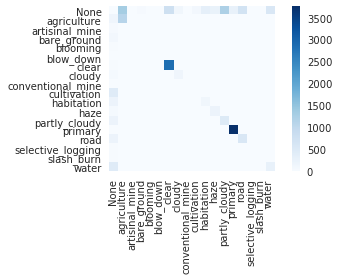

In [97]:
plot_confusion_matrix_dict(matrix_confusion_simple,90, outside_label="None")

### Baseline

In [98]:
model_base = create_model_model_base(img_dim=(128, 128, 3))

In [99]:
model_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 64)        8256      
__________

In [100]:
#Compile the model with Adam
model_base.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])

In [71]:
#callbacks
history_base = History()
callbacks_base = [history_base, 
                 EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
                 ModelCheckpoint(filepath='saved_models/model_base.weights.best.from_scratch.hdf5', verbose=1, 
                             save_best_only=True)]

In [72]:
#fit
epochs = 25
batchsize = 256

start = timeit.default_timer()

hist_base = model_base.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
                 epochs=epochs, batch_size=batchsize, callbacks=callbacks_base, verbose=1)

end = timeit.default_timer()-start
print("{} min".format(end/60))

Train on 32383 samples, validate on 4048 samples
Epoch 1/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.4545 - acc: 0.8610 - val_loss: 0.4193 - val_acc: 0.9080
Epoch 2/25
32383/32383 [==============================] - 40s 1ms/step - loss: 0.2470 - acc: 0.9099 - val_loss: 0.2791 - val_acc: 0.9097
Epoch 3/25
32383/32383 [==============================] - 40s 1ms/step - loss: 0.2327 - acc: 0.9108 - val_loss: 0.2357 - val_acc: 0.9113
Epoch 4/25
32383/32383 [==============================] - 40s 1ms/step - loss: 0.2208 - acc: 0.9155 - val_loss: 0.2179 - val_acc: 0.9172
Epoch 5/25
32383/32383 [==============================] - 40s 1ms/step - loss: 0.2133 - acc: 0.9181 - val_loss: 0.2123 - val_acc: 0.9177
Epoch 6/25
32383/32383 [==============================] - 40s 1ms/step - loss: 0.2093 - acc: 0.9189 - val_loss: 0.2092 - val_acc: 0.9183
Epoch 7/25
32383/32383 [==============================] - 40s 1ms/step - loss: 0.2068 - acc: 0.9196 - val_loss: 0.2066 - val_acc:

In [101]:
model_base.load_weights('saved_models/model_base.weights.best.from_scratch.hdf5')

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


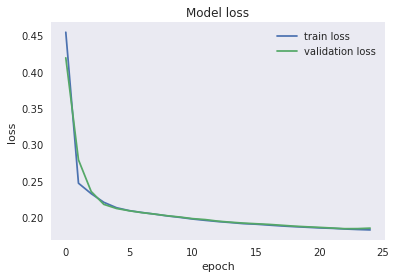

In [74]:
plt.plot(hist_base.history['loss'])
plt.plot(hist_base.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [102]:
# get predictions
baseline_predictions_base = [np.argmax(model_base.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
base_predictions_base = [model_base.predict(np.expand_dims(tensor, axis=0)) for tensor in test_tensors]

In [103]:
result_base= stack_vector(base_predictions_base,0.2)

In [104]:
print('F2 Score Model 0:', f2_score(test_targets, result_base))

F2 Score Model 0: 0.814921941129


In [105]:
### Confusion Matrix

In [106]:
predictions_base = one_hot_matrix(result_base)

In [107]:
matrix_confusion_base = create_confusion_matrix(data_targets, predictions_base)

In [108]:
full_evaluation_table(matrix_confusion_base)

Label   Gold  Guess  Precision    Recall
0         agriculture   1251   2463   0.460414  0.906475
1      artisinal_mine     35     12   0.416667  0.142857
2         bare_ground    102     59   0.237288  0.137255
3            blooming     27      0   0.000000  0.000000
4           blow_down     13      0   0.000000  0.000000
5               clear   2873   3534   0.808998  0.995127
6              cloudy    199    248   0.596774  0.743719
7   conventional_mine      7      0   0.000000  0.000000
8         cultivation    451    304   0.273026  0.184035
9          habitation    346    462   0.409091  0.546243
10               haze    262    516   0.428295  0.843511
11      partly_cloudy    714    815   0.575460  0.656863
12            primary   3759   4016   0.935757  0.999734
13               road    789   1365   0.460073  0.795944
14  selective_logging     28      0   0.000000  0.000000
15         slash_burn     24      0   0.000000  0.000000
16              water    716    807   0.340768  0.384078
17              [All]  11596  14601   0.670023  0.843653

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


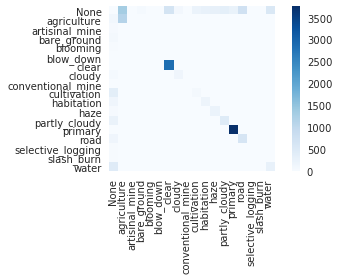

In [109]:
plot_confusion_matrix_dict(matrix_confusion_base,90, outside_label="None")

### Model 0

In [110]:
model_0 = create_model_model_0(img_dim=(128, 128, 3))

In [111]:
#Compile the model with Adam
model_0.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])

In [71]:
#callbacks
history = History()
callbacks = [history, 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath='saved_models/model_0.weights.best.from_scratch.hdf5', verbose=1, 
                             save_best_only=True)]

In [72]:
#fit
epochs = 25
batchsize = 256

start = timeit.default_timer()

hist_0 = model_0.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
                 epochs=epochs, batch_size=batchsize, callbacks=callbacks, verbose=1)

end = timeit.default_timer()-start
print("{} min".format(end/60))

Train on 32383 samples, validate on 4048 samples
Epoch 1/25
32383/32383 [==============================] - 46s 1ms/step - loss: 0.3640 - acc: 0.8883 - val_loss: 0.3765 - val_acc: 0.9090
Epoch 2/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.2277 - acc: 0.9142 - val_loss: 0.2484 - val_acc: 0.9172
Epoch 3/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.2113 - acc: 0.9191 - val_loss: 0.2122 - val_acc: 0.9193
Epoch 4/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.2019 - acc: 0.9217 - val_loss: 0.1995 - val_acc: 0.9224
Epoch 5/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.1928 - acc: 0.9249 - val_loss: 0.1902 - val_acc: 0.9261
Epoch 6/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.1862 - acc: 0.9275 - val_loss: 0.1851 - val_acc: 0.9286
Epoch 7/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.1822 - acc: 0.9294 - val_loss: 0.1804 - val_acc:

In [112]:
model_0.load_weights('saved_models/model_0.weights.best.from_scratch.hdf5')

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


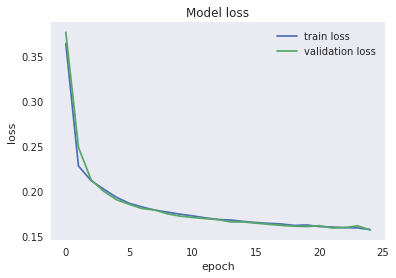

In [74]:
plt.plot(hist_0.history['loss'])
plt.plot(hist_0.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [113]:
# get predictions
baseline_predictions_0 = [np.argmax(model_0.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
base_predictions_0 = [model_0.predict(np.expand_dims(tensor, axis=0)) for tensor in test_tensors]

In [114]:
result_0 = stack_vector(base_predictions_0,0.2)

In [115]:
print('F2 Score Model 0:', f2_score(test_targets, result_0))

F2 Score Model 0: 0.853032276246


In [116]:
### Confusion Matrix

In [117]:
predictions_model_0 = one_hot_matrix(result_0)

In [118]:
matrix_confusion_model_0 = create_confusion_matrix(data_targets, predictions_model_0)

In [119]:
full_evaluation_table(matrix_confusion_model_0)

Label   Gold  Guess  Precision    Recall
0         agriculture   1251   1819   0.584387  0.849720
1      artisinal_mine     35     28   0.428571  0.342857
2         bare_ground    102     45   0.288889  0.127451
3            blooming     27      0   0.000000  0.000000
4           blow_down     13      0   0.000000  0.000000
5               clear   2873   3287   0.867965  0.993039
6              cloudy    199    296   0.564189  0.839196
7   conventional_mine      7      2   0.500000  0.142857
8         cultivation    451    544   0.301471  0.363636
9          habitation    346    478   0.418410  0.578035
10               haze    262    443   0.483070  0.816794
11      partly_cloudy    714    797   0.760351  0.848739
12            primary   3759   3974   0.943885  0.997872
13               road    789   1202   0.526622  0.802281
14  selective_logging     28      0   0.000000  0.000000
15         slash_burn     24      0   0.000000  0.000000
16              water    716   1075   0.388837  0.583799
17              [All]  11596  13990   0.721587  0.870559

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


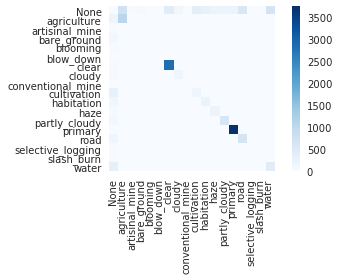

In [120]:
plot_confusion_matrix_dict(matrix_confusion_model_0,90, outside_label="None")

### Model 1

In [121]:
model_1 = create_model_model_1(img_dim=(128, 128, 3))

In [122]:
#Compile the model with Adam
model_1.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])

In [99]:
#callbacks
history_1 = History()
callbacks_1 = [history_1, 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath='saved_models/model_1.weights.best.from_scratch.hdf5', verbose=1, 
                             save_best_only=True)]

In [100]:
#fit
epochs = 25
batchsize = 256

start = timeit.default_timer()

hist_1 = model_1.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
                 epochs=epochs, batch_size=batchsize, callbacks=callbacks_1, verbose=1)

end = timeit.default_timer()-start
print("{} min".format(end/60))

Train on 32383 samples, validate on 4048 samples
Epoch 1/25
32383/32383 [==============================] - 338s 10ms/step - loss: 0.3152 - acc: 0.8986 - val_loss: 0.2751 - val_acc: 0.9122
Epoch 2/25
32383/32383 [==============================] - 325s 10ms/step - loss: 0.2127 - acc: 0.9181 - val_loss: 0.2303 - val_acc: 0.9145
Epoch 3/25
32383/32383 [==============================] - 325s 10ms/step - loss: 0.2028 - acc: 0.9203 - val_loss: 0.2002 - val_acc: 0.9225
Epoch 4/25
32383/32383 [==============================] - 325s 10ms/step - loss: 0.1935 - acc: 0.9244 - val_loss: 0.1895 - val_acc: 0.9247
Epoch 5/25
32383/32383 [==============================] - 325s 10ms/step - loss: 0.1862 - acc: 0.9270 - val_loss: 0.1842 - val_acc: 0.9273
Epoch 6/25
32383/32383 [==============================] - 325s 10ms/step - loss: 0.1816 - acc: 0.9288 - val_loss: 0.1784 - val_acc: 0.9307
Epoch 7/25
32383/32383 [==============================] - 325s 10ms/step - loss: 0.1784 - acc: 0.9300 - val_loss: 0.1

In [123]:
model_1.load_weights('saved_models/model_1.weights.best.from_scratch.hdf5')

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


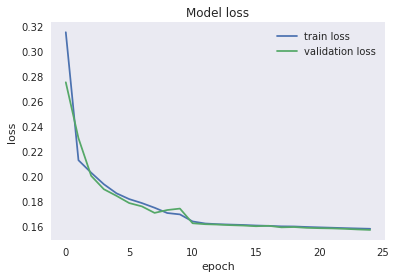

In [102]:
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [124]:
# get predictions
baseline_predictions_1 = [np.argmax(model_1.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
base_predictions_1 = [model_1.predict(np.expand_dims(tensor, axis=0)) for tensor in test_tensors]

In [125]:
result_1 = stack_vector(base_predictions_1,0.2)

In [126]:
print('F2 Score Model 1:', f2_score(test_targets, result_1))

F2 Score Model 1: 0.854603789514


In [127]:
### Confusion matrix

In [128]:
predictions_model_1 = one_hot_matrix(result_1)

In [129]:
matrix_confusion_model_1 = create_confusion_matrix(data_targets, predictions_model_1)

In [130]:
full_evaluation_table(matrix_confusion_model_1)

Label   Gold  Guess  Precision    Recall
0         agriculture   1251   1715   0.619242  0.848921
1      artisinal_mine     35     25   0.600000  0.428571
2         bare_ground    102     64   0.234375  0.147059
3            blooming     27      0   0.000000  0.000000
4           blow_down     13      0   0.000000  0.000000
5               clear   2873   3355   0.852757  0.995823
6              cloudy    199    294   0.578231  0.854271
7   conventional_mine      7      0   0.000000  0.000000
8         cultivation    451    491   0.305499  0.332594
9          habitation    346    506   0.407115  0.595376
10               haze    262    438   0.493151  0.824427
11      partly_cloudy    714    782   0.740409  0.810924
12            primary   3759   3976   0.943662  0.998138
13               road    789   1112   0.562950  0.793409
14  selective_logging     28      0   0.000000  0.000000
15         slash_burn     24      0   0.000000  0.000000
16              water    716   1029   0.427600  0.614525
17              [All]  11596  13787   0.731994  0.870300

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


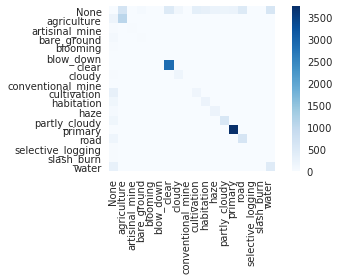

In [131]:
plot_confusion_matrix_dict(matrix_confusion_model_1,90, outside_label="None")

### Model VGG

In [132]:
model_VGG = create_model_VGG16(img_dim=(128, 128, 3))

In [133]:
model_VGG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 128, 128, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 17)                139281    
Total params: 14,853,981
Trainable params: 14,853,975
Non-trainable params: 6
_________________________________________________________________


In [134]:
#Compile the model with Adam
model_VGG.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])

In [90]:
#callbacks
history_VGG = History()
callbacks_VGG = [history_VGG, 
                 EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
                 ModelCheckpoint(filepath='saved_models/model_VGG.weights.hdf5', verbose=1, save_best_only=True)]

In [91]:
#fit
epochs = 25
batchsize = 256

start = timeit.default_timer()

hist_VGG = model_VGG.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
                 epochs=epochs, batch_size=batchsize, callbacks=callbacks_VGG, verbose=1)

end = timeit.default_timer()-start
print("{} min".format(end/60))

Train on 32383 samples, validate on 4048 samples
Epoch 1/25
32383/32383 [==============================] - 772s 24ms/step - loss: 0.1487 - acc: 0.9414 - val_loss: 0.2019 - val_acc: 0.9198
Epoch 2/25
32383/32383 [==============================] - 740s 23ms/step - loss: 0.1043 - acc: 0.9601 - val_loss: 0.1328 - val_acc: 0.9479
Epoch 3/25
32383/32383 [==============================] - 740s 23ms/step - loss: 0.0944 - acc: 0.9639 - val_loss: 0.1004 - val_acc: 0.9607
Epoch 4/25
32383/32383 [==============================] - 739s 23ms/step - loss: 0.0878 - acc: 0.9661 - val_loss: 0.1053 - val_acc: 0.9587
Epoch 5/25
32383/32383 [==============================] - 740s 23ms/step - loss: 0.0816 - acc: 0.9685 - val_loss: 0.0983 - val_acc: 0.9612
Epoch 6/25
32383/32383 [==============================] - 740s 23ms/step - loss: 0.0754 - acc: 0.9705 - val_loss: 0.0974 - val_acc: 0.9638
Epoch 7/25
32383/32383 [==============================] - 739s 23ms/step - loss: 0.0678 - acc: 0.9734 - val_loss: 0.0

In [135]:
model_VGG.load_weights('saved_models/model_VGG.weights.hdf5')

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


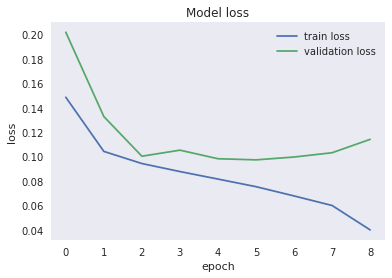

In [93]:
plt.plot(hist_VGG.history['loss'])
plt.plot(hist_VGG.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [136]:
# get predictions
baseline_predictions_VGG = [np.argmax(model_VGG.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
base_predictions_VGG = [model_VGG.predict(np.expand_dims(tensor, axis=0)) for tensor in test_tensors]

In [137]:
result_VGG = stack_vector(base_predictions_VGG,0.2)

In [138]:
print('F2 Score Model VGG:', f2_score(test_targets, result_VGG))

F2 Score Model VGG: 0.920522280995


In [139]:
### Confusion Matrix

In [140]:
predictions_model_VGG = one_hot_matrix(result_VGG)

In [141]:
matrix_confusion_model_VGG = create_confusion_matrix(data_targets, predictions_model_VGG)

In [142]:
full_evaluation_table(matrix_confusion_model_VGG)

Label   Gold  Guess  Precision    Recall
0         agriculture   1251   1604   0.737531  0.945643
1      artisinal_mine     35     26   0.884615  0.657143
2         bare_ground    102    156   0.294872  0.450980
3            blooming     27     14   0.428571  0.222222
4           blow_down     13      7   0.428571  0.230769
5               clear   2873   3002   0.942705  0.985033
6              cloudy    199    284   0.676056  0.964824
7   conventional_mine      7      7   0.285714  0.285714
8         cultivation    451    462   0.573593  0.587583
9          habitation    346    464   0.553879  0.742775
10               haze    262    380   0.584211  0.847328
11      partly_cloudy    714    769   0.881664  0.949580
12            primary   3759   3852   0.970924  0.994945
13               road    789    857   0.793466  0.861850
14  selective_logging     28     19   0.315789  0.214286
15         slash_burn     24      0   0.000000  0.000000
16              water    716    714   0.774510  0.772346
17              [All]  11596  12617   0.846953  0.921525

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


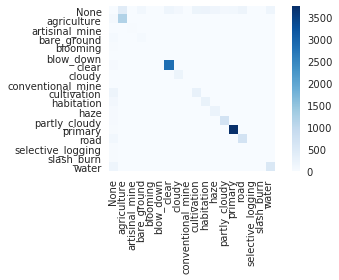

In [143]:
plot_confusion_matrix_dict(matrix_confusion_model_VGG,90, outside_label="None")

### Model 3-networks

In [80]:
#labels classes
weather_labels = ['clear','partly_cloudy','cloudy','haze']
common_labels = ['primary','water','habitation','agriculture','road','cultivation','bare_ground']
rare_labels = ['selective_logging', 'blooming', 'conventional_mine', 'slash_burn' , 'blow_down', 'artisinal_mine']

In [81]:
weather_labels_set = set(weather_labels)
common_labels_set = set(common_labels)
rare_labels_set = set(rare_labels)

In [82]:
pd.options.mode.chained_assignment = None

In [83]:
def split_targets(targets):
    
    """
    targets: Pandas Dataframe of labels
    """
    
    weather_files =targets.copy()
    common_files =targets.copy()
    rare_files = targets.copy()
    
    for i, element in enumerate(targets['tags']):

        labels = element.split(' ')
        labels_set = set(labels)
        weather = weather_labels_set.intersection(labels_set)
        common_land = common_labels_set.intersection(labels_set)
        rare_land = rare_labels_set.intersection(labels_set)

        weather_string = ' '.join(weather)
        common_string = ' '.join(common_land)
        rare_string = ' '.join(rare_land)

        weather_files.replace(to_replace=weather_files.tags.iloc[i],value=weather_string, inplace=True)
        common_files.replace(to_replace=common_files.tags.iloc[i],value=common_string, inplace=True)
        rare_files.replace(to_replace=rare_files.tags.iloc[i],value=rare_string, inplace=True)
    
    return weather_files, common_files, rare_files

In [84]:
#Split in 3 categories: weather, commong and rare

In [85]:
train_weather_files, train_common_files, train_rare_files = split_targets(train_files)

In [86]:
val_weather_files, val_common_files, val_rare_files = split_targets(val_files)

In [87]:
test_weather_files, test_common_files, test_rare_files = split_targets(test_files)

In [88]:
#Binarise the outputs

In [89]:
train_targets_weather = one_hot(train_weather_files['tags'])
valid_targets_weather = one_hot(val_weather_files['tags'])
test_targets_weather = one_hot(test_weather_files['tags'])

In [90]:
train_targets_common = one_hot(train_common_files['tags'])
valid_targets_common = one_hot(val_common_files['tags'])
test_targets_common = one_hot(test_common_files['tags'])

In [91]:
train_targets_rare = one_hot(train_rare_files['tags'])
valid_targets_rare = one_hot(val_rare_files['tags'])
test_targets_rare = one_hot(test_rare_files['tags'])

In [92]:
#Test

In [93]:
train_weather_files['tags'][:10]

0     haze
1    clear
2    clear
3    clear
4    clear
5     haze
6    clear
7     haze
8    clear
9    clear
Name: tags, dtype: object

In [94]:
train_targets_weather[:10]

array([[0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [95]:
test_targets_weather[:10]

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [96]:
test_targets_common[:10]

array([[0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 1, 1, 0],
       [1, 0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 1, 1]])

In [97]:
test_targets_rare[:10]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [98]:
#function for concatenate the output

In [99]:
def concatenate_output(weather_data, common_data,rare_data):
    
    list_vectors = []
    for i in range(len(weather_data)):
        w = weather_data[i]
        c = common_data[i]
        r = rare_data[i]
        new_vector = np.concatenate((w,c,r))
        list_vectors.append(new_vector)
    
    return np.vstack(list_vectors)

#### Model 2a: Weather

In [100]:
#Create Model a: Weather

In [101]:
model_2a = create_model_model_comb_1(img_dim=(128, 128, 3))
model_2a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 64)        8256      
__________

In [102]:
#Compile the model with Adam
model_2a.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics = ['accuracy'])

In [167]:
#callbacks
history_2a = History()
callbacks_2a = [history_2a, 
                 EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
                 ModelCheckpoint(filepath='saved_models/model_2a.weights.hdf5', verbose=1, save_best_only=True)]

In [168]:
#fit
epochs = 25
batchsize = 256

start = timeit.default_timer()

hist_2a = model_2a.fit(train_tensors, train_targets_weather, validation_data=(valid_tensors, valid_targets_weather),
                 epochs=epochs, batch_size=batchsize, callbacks=callbacks_2a, verbose=1)

end = timeit.default_timer()-start
print("{} min".format(end/60))

Train on 32383 samples, validate on 4048 samples
Epoch 1/25
32383/32383 [==============================] - 44s 1ms/step - loss: 0.8044 - acc: 0.7142 - val_loss: 0.8399 - val_acc: 0.7053
Epoch 2/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.5687 - acc: 0.7779 - val_loss: 0.6617 - val_acc: 0.7213
Epoch 3/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.5095 - acc: 0.8101 - val_loss: 0.5378 - val_acc: 0.7843
Epoch 4/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.4747 - acc: 0.8220 - val_loss: 0.4597 - val_acc: 0.8298
Epoch 5/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.4430 - acc: 0.8345 - val_loss: 0.4398 - val_acc: 0.8288
Epoch 6/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.4268 - acc: 0.8391 - val_loss: 0.4158 - val_acc: 0.8444
Epoch 7/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.4151 - acc: 0.8445 - val_loss: 0.3941 - val_acc:

In [103]:
model_2a.load_weights('saved_models/model_2a.weights.hdf5')

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


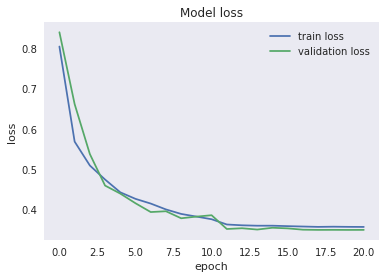

In [170]:
plt.plot(hist_2a.history['loss'])
plt.plot(hist_2a.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [104]:
# get predictions
baseline_predictions_2a = [np.argmax(model_2a.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
base_predictions_2a = [model_2a.predict(np.expand_dims(tensor, axis=0)) for tensor in test_tensors]

In [105]:
baseline_predictions_2a[:5]

[0, 0, 3, 0, 0]

In [106]:
def weather_results(result):

    list_vectors = []
    for i in result:
        indice = i
        list_new = np.array([0,0,0,0])
        list_new[indice] = 1
        list_vectors.append(list_new)
    return np.vstack(list_vectors)

In [107]:
result_2a = weather_results(baseline_predictions_2a)

In [108]:
result_2a[:5]

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

#### Model 2b: Common

In [109]:
#Create Model b: Common 

In [110]:
model_2b = create_model_model_comb_2(img_dim=(128, 128, 3))
model_2b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 64)        8256      
__________

In [111]:
#Compile the model with Adam
model_2b.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])

In [175]:
#callbacks
history_2b = History()
callbacks_2b = [history_2b, 
                 EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
                 ModelCheckpoint(filepath='saved_models/model_2b.weights.hdf5', verbose=1, save_best_only=True)]

In [176]:
#fit
epochs = 25
batchsize = 256

start = timeit.default_timer()

hist_2b = model_2b.fit(train_tensors, train_targets_common, validation_data=(valid_tensors, valid_targets_common),
                 epochs=epochs, batch_size=batchsize, callbacks=callbacks_2b, verbose=1)

end = timeit.default_timer()-start
print("{} min".format(end/60))

Train on 32383 samples, validate on 4048 samples
Epoch 1/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.4476 - acc: 0.8324 - val_loss: 0.4846 - val_acc: 0.8620
Epoch 2/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.3342 - acc: 0.8677 - val_loss: 0.3527 - val_acc: 0.8686
Epoch 3/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.3168 - acc: 0.8743 - val_loss: 0.3142 - val_acc: 0.8752
Epoch 4/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.3058 - acc: 0.8787 - val_loss: 0.3001 - val_acc: 0.8804
Epoch 5/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.2967 - acc: 0.8816 - val_loss: 0.2932 - val_acc: 0.8842
Epoch 6/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.2915 - acc: 0.8829 - val_loss: 0.2892 - val_acc: 0.8853
Epoch 7/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.2870 - acc: 0.8844 - val_loss: 0.2864 - val_acc:

In [112]:
model_2b.load_weights('saved_models/model_2b.weights.hdf5')

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


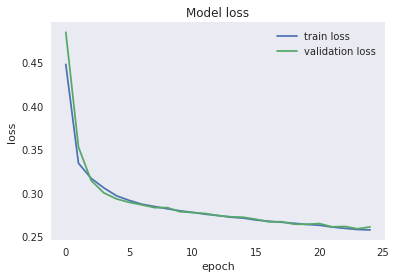

In [178]:
plt.plot(hist_2b.history['loss'])
plt.plot(hist_2b.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [113]:
# get predictions
baseline_predictions_2b = [np.argmax(model_2b.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
base_predictions_2b = [model_2b.predict(np.expand_dims(tensor, axis=0)) for tensor in test_tensors]

In [114]:
result_2b = stack_vector(base_predictions_2b,0.2)

#### Model 2c: Rare

In [181]:
#Create Model c: Rare

In [115]:
model_2c = create_model_model_comb_3(img_dim=(128, 128, 3))
model_2c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 64)        8256      
__________

In [116]:
#Compile the model with Adam
model_2c.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])

In [184]:
#callbacks
history_2c = History()
callbacks_2c = [history_2c, 
                 EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
                 ModelCheckpoint(filepath='saved_models/model_2c.weights.hdf5', verbose=1, save_best_only=True)]

In [185]:
#fit
epochs = 25
batchsize = 256

start = timeit.default_timer()

hist_2c = model_2c.fit(train_tensors, train_targets_rare, validation_data=(valid_tensors, valid_targets_rare),
                 epochs=epochs, batch_size=batchsize, callbacks=callbacks_2c, verbose=1)

end = timeit.default_timer()-start
print("{} min".format(end/60))

Train on 32383 samples, validate on 4048 samples
Epoch 1/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.2084 - acc: 0.9690 - val_loss: 0.1526 - val_acc: 0.9935
Epoch 2/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.0451 - acc: 0.9942 - val_loss: 0.0641 - val_acc: 0.9935
Epoch 3/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.0409 - acc: 0.9942 - val_loss: 0.0430 - val_acc: 0.9935
Epoch 4/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.0385 - acc: 0.9942 - val_loss: 0.0403 - val_acc: 0.9935
Epoch 5/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.0365 - acc: 0.9942 - val_loss: 0.0382 - val_acc: 0.9935
Epoch 6/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.0348 - acc: 0.9942 - val_loss: 0.0368 - val_acc: 0.9935
Epoch 7/25
32383/32383 [==============================] - 42s 1ms/step - loss: 0.0334 - acc: 0.9942 - val_loss: 0.0350 - val_acc:

In [117]:
model_2c.load_weights('saved_models/model_2c.weights.hdf5')

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


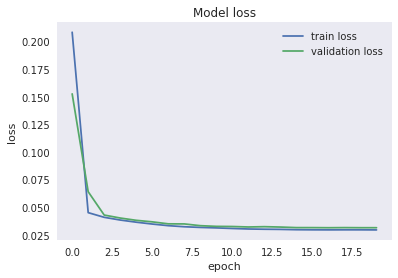

In [187]:
plt.plot(hist_2c.history['loss'])
plt.plot(hist_2c.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [118]:
# get predictions
baseline_predictions_2c = [np.argmax(model_2c.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
base_predictions_2c = [model_2c.predict(np.expand_dims(tensor, axis=0)) for tensor in test_tensors]

In [119]:
result_2c = stack_vector(base_predictions_2c,0.2)

In [120]:
result_2a[:5]

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [121]:
result_2b[:5]

array([[0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 1, 1],
       [1, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 1, 1]])

In [122]:
result_2c[:5]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [123]:
test_targets_rare[:5]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [124]:
#Concatenate predictions and gold labels

In [125]:
result_2final = concatenate_output(result_2a, result_2b, result_2c)

In [126]:
result_2final[:5]

array([[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]])

In [127]:
test_targets_new = concatenate_output(test_targets_weather,test_targets_common,test_targets_rare)

In [128]:
test_targets_new[:5]

array([[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]])

In [129]:
#F2 score

In [130]:
print('F2 Score Model 3-network:', f2_score(test_targets_new, result_2final)) 

F2 Score Model 3-network: 0.836721353781


In [132]:
#Confusion matrix

In [133]:
def concatenate_output_1(weather_data, common_data,rare_data):
    
    list_vectors = []
    for i in range(len(weather_data)):
        w = weather_data[i]
        c = common_data[i]
        r = rare_data[i]
        new_vector = np.concatenate((w,c,r))
        list_vectors.append(new_vector)
    
    return list_vectors

In [134]:
mlb_2a = MultiLabelBinarizer()
mlb_2a.fit(s.split() for s in test_weather_files['tags'])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [135]:
def one_hot_2a(prediction):
    
    list_final=[]
    
    for p in prediction:
        p = p.reshape(1,4)
        y_targets = mlb_2a.inverse_transform(p)
        list_1 = [elem for elem in y_targets[0]]
        list_final.append(list_1)
    return list_final

In [136]:
predictions_model_2a = one_hot_2a(result_2a)

In [137]:
mlb_2b = MultiLabelBinarizer()
mlb_2b.fit(s.split() for s in test_common_files['tags'])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [138]:
def one_hot_2b(prediction):
    
    list_final=[]
    
    for p in prediction:
        p = p.reshape(1,7)
        y_targets = mlb_2b.inverse_transform(p)
        list_1 = [elem for elem in y_targets[0]]
        list_final.append(list_1)
    return list_final

In [139]:
predictions_model_2b = one_hot_2b(result_2b)

In [140]:
mlb_2c = MultiLabelBinarizer()
mlb_2c.fit(s.split() for s in test_rare_files['tags'])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [141]:
def one_hot_2c(prediction):
    
    list_final=[]
    
    for p in prediction:
        p = p.reshape(1,6)
        y_targets = mlb_2c.inverse_transform(p)
        list_1 = [elem for elem in y_targets[0]]
        list_final.append(list_1)
    return list_final

In [142]:
predictions_model_2c = one_hot_2c(result_2c)

In [145]:
predictions_model_2 = concatenate_output_1(predictions_model_2a,predictions_model_2b,predictions_model_2c)

In [146]:
#Gold labels

In [147]:
data_targets_weather = [item.split()for item in test_weather_files['tags'].tolist()]

In [148]:
data_targets_common = [item.split()for item in test_common_files['tags'].tolist()]

In [149]:
data_targets_rare = [item.split() for item in test_rare_files['tags'].tolist()]

In [150]:
#Test

In [151]:
data_targets_weather[:5]

[['clear'], ['clear'], ['partly_cloudy'], ['clear'], ['clear']]

In [152]:
data_targets_common[:5]

[['primary'],
 ['primary'],
 ['road', 'primary', 'agriculture'],
 ['habitation', 'primary', 'water'],
 ['road', 'primary', 'water']]

In [153]:
data_targets_rare[:5]

[[], [], [], [], []]

In [154]:
#Concatenate

In [155]:
data_targets_new = concatenate_output_1(data_targets_weather,data_targets_common,data_targets_rare)

In [156]:
#Run scripts to create matrix

In [157]:
matrix_confusion_model_2 = create_confusion_matrix(data_targets_new, predictions_model_2)

In [158]:
full_evaluation_table(matrix_confusion_model_2)

Label   Gold  Guess  Precision    Recall
0         agriculture   1251   1830   0.590710  0.864109
1      artisinal_mine     35     23   0.652174  0.428571
2         bare_ground    102     27   0.370370  0.098039
3            blooming     27      0   0.000000  0.000000
4           blow_down     13      0   0.000000  0.000000
5               clear   2873   3117   0.900866  0.977376
6              cloudy    199    165   0.721212  0.597990
7   conventional_mine      7      0   0.000000  0.000000
8         cultivation    451    439   0.321185  0.312639
9          habitation    346    420   0.457143  0.554913
10               haze    262    242   0.648760  0.599237
11      partly_cloudy    714    524   0.895038  0.656863
12            primary   3759   3994   0.940160  0.998936
13               road    789   1119   0.554066  0.785805
14  selective_logging     28      0   0.000000  0.000000
15         slash_burn     24      0   0.000000  0.000000
16              water    716   1125   0.392889  0.617318
17              [All]  11596  13025   0.753090  0.845895

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


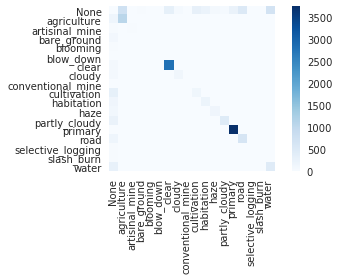

In [159]:
plot_confusion_matrix_dict(matrix_confusion_model_2,90, outside_label="None")